In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.0


In [39]:
# Mål: Gjør binary classification på om dem e disease free nå

cancer_type_columns = [
#    "Neoplasm Disease Stage American Joint Committee on Cancer Code", 
   "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage", # Denne hjalp
# #    "American Joint Committee on Cancer Metastasis Stage Code", 
# #    "American Joint Committee on Cancer Lymph Node Stage Code.1", 
   "American Joint Committee on Cancer Lymph Node Stage Code", # Denne hjalp
   "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code", # Denne hjalp
# #    "Neoplasm Disease Stage American Joint Committee on Cancer Code.1", 
   "American Joint Committee on Cancer Publication Version Type", # Har mye å si
# #    "American Joint Committee on Cancer Tumor Stage Code",
#    "Cancer Type Detailed", # Bidrar ikke positivt
#    "Fraction Genome Altered", # Bidrar litt positivt
   "Mutation Count", # Bidrar positivt
    "Sample Initial Weight", # Hjalp veldig
    # "TMB (nonsynonymous)", # Hjalp ikkje
]

pd_df_original = pd.read_csv(
    "./Testicular Cancer Dataset.csv",
    # names=[*cancer_type_columns, "Disease Free (Months)"]
    usecols=[*cancer_type_columns, 'Disease Free (Months)', 'Postoperative tx', 'Disease Free Status'],
    na_values=['NA'],
    keep_default_na=False
)

prevLength = len(pd_df_original)

pd_df_original = pd_df_original.dropna()

print(f'Dropped {prevLength - len(pd_df_original)} values, leaving us with {len(pd_df_original)}')

for column in cancer_type_columns:
    domain = dict.fromkeys(pd_df_original[column].unique().tolist())
    for value in domain:
        domain[value] = (pd_df_original[column] == value).sum()
    print(f'    Column "{column}"', domain)

pd_df = pd_df_original.copy()
# pd_df = pd_df.loc[pd_df['Disease Free Status'] == '1:Recurred/Progressed']

# target = pd_df.apply(lambda p: p['Disease Free (Months)'] * (1 if p['Disease Free Status'] == '1:Recurred/Progressed' else 2), axis=1)

target = pd_df.pop('Disease Free Status')

target = target.replace('1:Recurred/Progressed', 1)
target = target.replace('0:DiseaseFree', 0)
# pd_df.pop('Disease Free Status')

# target = np.log10(target)

inputs = {}

numericInputsBool = False

for name, column in pd_df.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        numericInputsBool = True
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)


if numericInputsBool:
    # Vi har ingen numeric inputs pr no
    numeric_inputs = {name:input for name,input in inputs.items()
                    if input.dtype==tf.float32}
    x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = tf.keras.layers.Normalization()
    norm.adapt(np.array(pd_df_original[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]
else:
    preprocessed_inputs = []

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(pd_df[name]))
    one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

# preprocessed_inputs

preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)

preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# Nå visualiserings greie
# tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)


# Split training og testing data
# Random state 5 e dårlig, 19 og 4 e ganske bra, 2 e hinsides bra!
random_state=2

train_input, test_input = train_test_split(pd_df, test_size=0.2, random_state=random_state)
train_output, test_output = train_test_split(target, test_size=0.2, random_state=random_state)

train_input = {name: np.array(value) for name, value in train_input.items()}
test_input = {name: np.array(value) for name, value in test_input.items()}

# Must split my_features_dict into training and testing data
# Split on the same indexes with target, my_features_dict[0] corresponds to target[0] and so on

def model_func(preprocessing, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2) 
    ])

    # Det e ingen outputs som er lavere enn null, så vi kan trygt bruk activation function relu på output


    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(16, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(4, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.Dense(1)

    preprocessed_inputs = preprocessing(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.legacy.Adam()
    )
    return model

model = model_func(preprocessing, inputs)

print(f'Training set length: {len(train_output)}, Test set length: {len(test_output)}')

Dropped 49 values, leaving us with 107
    Column "Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage" {'M0': 101, 'M1b': 2, 'M1a': 3, 'M1': 1}
    Column "American Joint Committee on Cancer Lymph Node Stage Code" {'T1': 62, 'T2': 42, 'T3': 3}
    Column "Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code" {'N0': 44, 'N2': 2, 'N1': 10, 'NX': 51}
    Column "American Joint Committee on Cancer Publication Version Type" {'7th': 45, '6th': 40, '5th': 12, '4th': 9, '3rd': 1}
    Column "Mutation Count" {41.0: 1, 57.0: 4, 33.0: 2, 43.0: 4, 46.0: 4, 66.0: 6, 68.0: 2, 61.0: 5, 49.0: 4, 59.0: 4, 42.0: 1, 52.0: 2, 38.0: 1, 37.0: 1, 56.0: 2, 27.0: 1, 50.0: 4, 67.0: 2, 54.0: 4, 60.0: 3, 69.0: 3, 73.0: 3, 79.0: 1, 72.0: 2, 40.0: 3, 45.0: 3, 58.0: 7, 55.0: 2, 48.0: 4, 44.0: 1, 65.0: 3, 30.0: 1, 98.0: 1, 53.0: 3, 31.0: 1, 47.0: 2, 426.0: 1, 25.0: 1, 62.0: 1, 64.0: 2, 51.0: 1, 101.0: 1, 39.0: 1, 36.0: 1, 28.0: 1}
    Column "Sample Initial Weight" {2

(0.5445472002029419, 0.515278697013855)
(0.47650495171546936, 0.43403589725494385)
(0.4374158978462219, 0.3926091492176056)
(0.41706424951553345, 0.38570308685302734)
(0.3977469801902771, 0.3747638463973999)
(0.38505613803863525, 0.3522413969039917)
(0.371855229139328, 0.34959542751312256)
(0.361441045999527, 0.34539294242858887)
(0.3552626073360443, 0.36039233207702637)
(0.35463324189186096, 0.35460156202316284)
(0.34591561555862427, 0.3446047902107239)
(0.33624330163002014, 0.33442574739456177)
(0.3346363604068756, 0.34660691022872925)
(0.3401154577732086, 0.34130430221557617)
(0.335319846868515, 0.3517695963382721)
(0.32562097907066345, 0.3402003347873688)
(0.3205111026763916, 0.3477172553539276)
(0.3168114721775055, 0.3473224937915802)
(0.3175238072872162, 0.33422112464904785)
(0.3079454004764557, 0.3290714621543884)
(0.3078370988368988, 0.3263768255710602)
(0.3053799569606781, 0.3399491608142853)
(0.29949161410331726, 0.3322261571884155)
(0.29799753427505493, 0.3458459675312042)
(

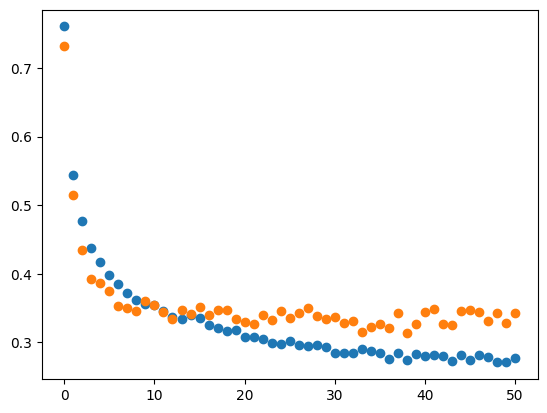

In [40]:
results = []

results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
for i in range(50):
    model.fit(x=train_input, y=train_output, epochs=100, verbose=0)
    results.append((model.evaluate(train_input, train_output, verbose=0), model.evaluate(test_input, test_output, verbose=0)))
    print(results[-1])

fig, ax = plt.subplots()
ax.plot([r[0] for r in results], 'o')
ax.plot([r[1] for r in results], 'o')

print(results[-1][1])

plt.show()